# Libs, cuda etc.

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from torch.nn.utils import clip_grad_norm_

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
IMG_SIZE_8BIT = 32
IMG_SIZE_RGB = 500

# Common

In [50]:
def get_transform_matrix(theta, scale_factor, trans_x, trans_y, device):
    theta_cos = torch.cos(input=theta)
    theta_sin = torch.sin(input=theta)
    return torch.stack(tensors=[scale_factor*theta_cos, scale_factor * (-theta_sin), trans_x, scale_factor * theta_sin, scale_factor*theta_cos, trans_y]).view(2,3)


def transform_img(x, theta, scale_factor, trans_x, trans_y, device):
    scale_mat = get_transform_matrix(theta = theta, scale_factor=scale_factor, trans_x=trans_x, trans_y=trans_y,device=device).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x


def transform_img_with_matrix(x, trans_matrix):
    scale_mat = trans_matrix.view(2,3).unsqueeze(dim=0).repeat(x.shape[0],1,1)    # repeat for whole batch
    grid = F.affine_grid(theta=scale_mat, size=x.size(), align_corners=False)
    x = F.grid_sample(input=x, grid=grid, align_corners=False)
    return x

In [90]:
def convert_img_to_gray(image, path=None):
    imgGray = image.convert('L')
    if path:
        imgGray.save(path)
    return imgGray

def get_data_8b(img_in_path, img_out_path, img_size):
    img_in = Image.open(img_in_path+".jpg")
    img_out = Image.open(img_out_path+".jpg")
    img_in = convert_img_to_gray(img_in, img_in_path+"_bw.jpg")
    img_out = convert_img_to_gray(img_out, img_out_path+"_bw.jpg")
    
    transform = T.Compose(transforms=[
        T.ToPILImage(),
        T.Resize(size=(img_size, img_size)),
        T.ToTensor()
    ])
    
    img_in = transform(read_image(img_in_path+"_bw.jpg"))
    img_out = transform(read_image(img_out_path+"_bw.jpg"))
    
    return img_in, img_out

def get_data_rgb(img_in_path, img_out_path, img_size):
    transform = T.Compose(transforms=[
        T.ToPILImage(),
        T.Resize(size=(img_size, img_size)),
        T.ToTensor()
    ])
    im_in = transform(read_image(img_in_path+".jpg"))
    im_out = transform(read_image(img_out_path+".jpg"))
    return im_in, im_out

In [52]:
def show_im(img):
    if len(img.shape) == 4:
        display(T.ToPILImage()(img.squeeze(0)))
    elif len(img.shape) == 3:
        display(T.ToPILImage()(img))
    else:
        raise ValueError("Image must be 3 or 4 dimensional")

In [53]:
class CustomTestDataset(Dataset):
    def __init__(self, image_in, image_out):
        self.img_labels = (image_in, image_out)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img_labels[0], self.img_labels[1]

In [55]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [56]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=50):
    best_loss = 1e10
    train_losses = []
 
    for epoch in range(0, epochs):
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}')
    
    return model, optimizer, train_losses

# 8-bit images:

In [80]:
class AttentionTransformation8Bit(nn.Module):

    def __init__(self, device, img_size):
        super().__init__()
        
        self.device = device
        self.img_size = img_size
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=6, out_channels=3, kernel_size=2, stride=2),
            
        )
        
        self.transf_ff = nn.Sequential(
            nn.Linear(in_features=108, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=4)
        )
        
        self.scale_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
        )
        
        self.rot_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1)
        )
        
        self.trans_x_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        ) 
            
        self.trans_y_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        )
        
        # zeroing transformation weights
        with torch.no_grad():
            self.transf_ff[0].weight.data.zero_()
            self.transf_ff[2].weight.data.zero_()            
            self.scale_ff[0].weight.data.zero_()            
            self.rot_ff[0].weight.data.zero_()            
            self.trans_x_ff[0].weight.data.zero_()                       
            self.trans_y_ff[0].weight.data.zero_()


    def forward(self, x_inp, is_evaling=False):
        x = self.feature_extractor(x_inp)
        x = torch.flatten(x, 1)
        trans = self.transf_ff(x)
        
        trans_x = self.trans_x_ff(trans)
        trans_y = self.trans_y_ff(trans)
        scale_factor = torch.exp(self.scale_ff(trans))
        rot_factor = self.rot_ff(trans)
        img = transform_img(x=x_inp, theta=rot_factor, scale_factor=scale_factor, device=self.device, trans_x=trans_x, trans_y=trans_y)
        
        if is_evaling:
            print("Params:\n-Scale: " + str(scale_factor)+ "\n-Theta: " + str(rot_factor)+"\n-Trans_x: " + str(trans_x)+"\n-Trans_y: " + str(trans_y))
        
        return img

In [87]:
def evaluate_model_8b(model, train_loader, device):
  img_inp, img_out = next(iter(train_loader))
  
  print("Proposed transformation", end=" ")
  with torch.no_grad():
    y = model(img_inp.to(device),is_evaling=True)
  
  print(f"Shape of prediction: {y.shape}")
  
  print(f"Images:")
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  ax[0].title.set_text("Input")
  ax[0].imshow(img_inp.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
  ax[1].title.set_text("Prediction")
  ax[1].imshow(y.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
  ax[2].title.set_text("Target")
  ax[2].imshow(img_out.detach().cpu().squeeze(0).permute(1,2,0), cmap='gray')
  plt.show()
  
def E2E_8b(im_in, im_out, lr, n_epochs, seed, device, prnt_every=30):
    print("Data preparation")
    img_in, img_out = get_data_8b(img_in_path=im_in, img_out_path=im_out, img_size=IMG_SIZE_8BIT)
    train_loader = DataLoader(dataset=CustomTestDataset(img_in, img_out), batch_size=1, shuffle=False)
    torch.manual_seed(seed)
    
    print("Model training")
    model = AttentionTransformation8Bit(device, IMG_SIZE_8BIT).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction="mean")
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, n_epochs, device, print_every=prnt_every)
    
    print("Model evaluation")
    evaluate_model_8b(model, train_loader, device)

Data preparation
Model training
00:11:57 --- Epoch: 29	Train loss: 0.0355
00:11:57 --- Epoch: 59	Train loss: 0.0262
00:11:58 --- Epoch: 89	Train loss: 0.0168
00:11:58 --- Epoch: 119	Train loss: 0.0168
00:11:59 --- Epoch: 149	Train loss: 0.0168
Model evaluation
Proposed transformation Params:
-Scale: tensor([[0.5583]], device='cuda:0')
-Theta: tensor([[0.0002]], device='cuda:0')
-Trans_x: tensor([[-0.1249]], device='cuda:0')
-Trans_y: tensor([[0.0094]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


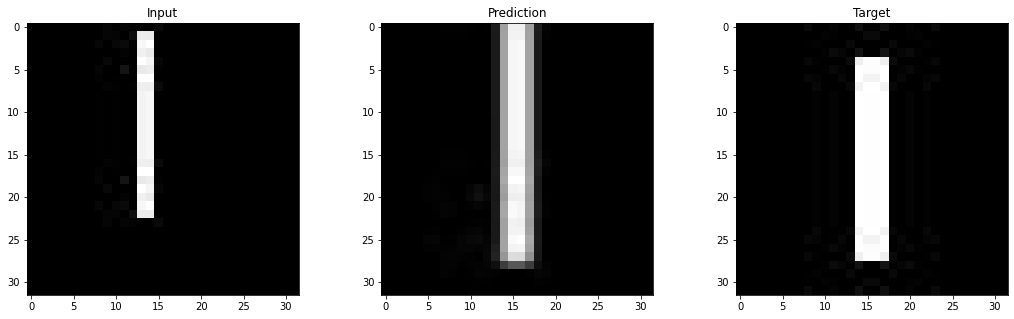

In [66]:
E2E_8b(im_in='img/8bit/one_top_left', im_out='img/8bit/one_center', lr=0.01, n_epochs=150, seed=420, device="cuda", prnt_every=30)

Data preparation
Model training
00:12:02 --- Epoch: 149	Train loss: 0.0866
00:12:04 --- Epoch: 299	Train loss: 0.0436
00:12:07 --- Epoch: 449	Train loss: 0.0180
00:12:10 --- Epoch: 599	Train loss: 0.0142
Model evaluation
Proposed transformation Params:
-Scale: tensor([[1.6443]], device='cuda:0')
-Theta: tensor([[-0.0006]], device='cuda:0')
-Trans_x: tensor([[0.2055]], device='cuda:0')
-Trans_y: tensor([[0.0574]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


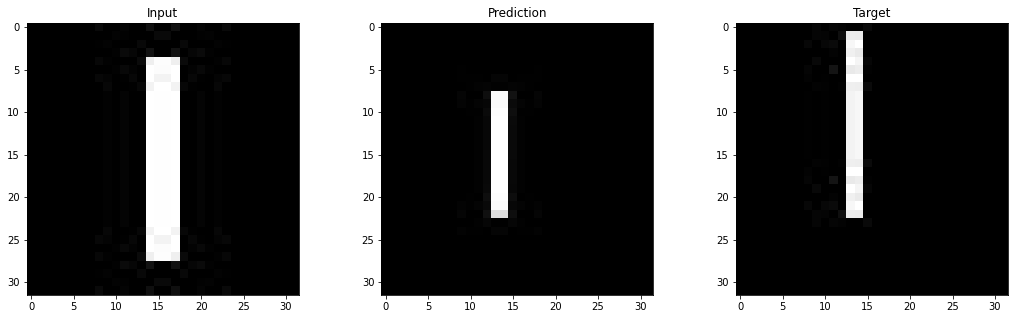

In [67]:
E2E_8b(im_in='img/8bit/one_center', im_out='img/8bit/one_top_left', lr=0.0001, n_epochs=700, seed=420, device="cuda", prnt_every=150)

Data preparation
Model training
00:12:14 --- Epoch: 99	Train loss: 0.0777
00:12:16 --- Epoch: 199	Train loss: 0.0756
00:12:18 --- Epoch: 299	Train loss: 0.0637
00:12:19 --- Epoch: 399	Train loss: 0.0479
00:12:21 --- Epoch: 499	Train loss: 0.0313
00:12:23 --- Epoch: 599	Train loss: 0.0139
00:12:25 --- Epoch: 699	Train loss: 0.0133
00:12:27 --- Epoch: 799	Train loss: 0.0132
Model evaluation
Proposed transformation Params:
-Scale: tensor([[0.5682]], device='cuda:0')
-Theta: tensor([[0.7138]], device='cuda:0')
-Trans_x: tensor([[-0.1912]], device='cuda:0')
-Trans_y: tensor([[-0.3010]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


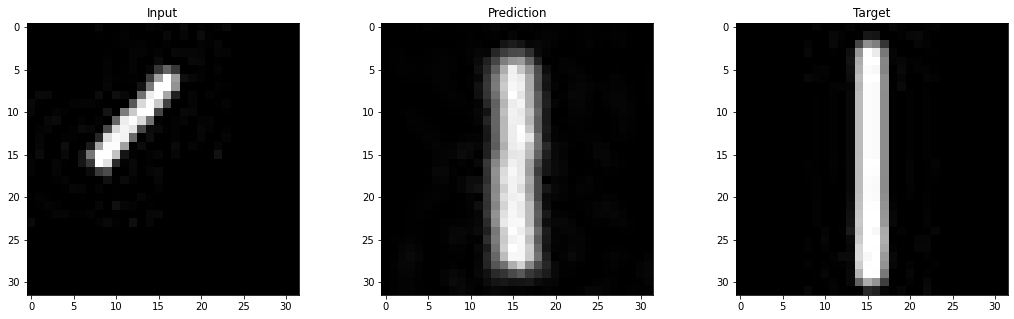

In [68]:
E2E_8b(im_in='img/8bit/one_rotated', im_out='img/8bit/one_center_2', lr=0.0001, n_epochs=800, seed=420, device="cuda", prnt_every=100)

Data preparation
Model training
00:12:29 --- Epoch: 99	Train loss: 0.1328
00:12:31 --- Epoch: 199	Train loss: 0.1190
00:12:33 --- Epoch: 299	Train loss: 0.1156
00:12:35 --- Epoch: 399	Train loss: 0.1110
00:12:37 --- Epoch: 499	Train loss: 0.0903
00:12:38 --- Epoch: 599	Train loss: 0.0518
00:12:40 --- Epoch: 699	Train loss: 0.0113
00:12:42 --- Epoch: 799	Train loss: 0.0113
Model evaluation
Proposed transformation Params:
-Scale: tensor([[0.4931]], device='cuda:0')
-Theta: tensor([[0.6207]], device='cuda:0')
-Trans_x: tensor([[-0.4164]], device='cuda:0')
-Trans_y: tensor([[-0.3742]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


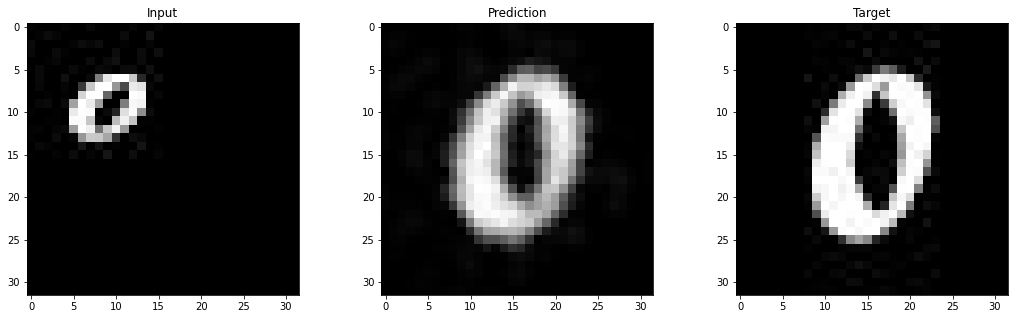

In [69]:
E2E_8b(im_in='img/8bit/zero_tf', im_out='img/8bit/zero_centered', lr=0.0001, n_epochs=800, seed=420, device="cuda", prnt_every=100)

Data preparation
Model training
00:12:44 --- Epoch: 99	Train loss: 0.1069
00:12:46 --- Epoch: 199	Train loss: 0.0447
00:12:47 --- Epoch: 299	Train loss: 0.0151
00:12:49 --- Epoch: 399	Train loss: 0.0097
00:12:51 --- Epoch: 499	Train loss: 0.0050
00:12:53 --- Epoch: 599	Train loss: 0.0047
00:12:55 --- Epoch: 699	Train loss: 0.0044
00:12:56 --- Epoch: 799	Train loss: 0.0044
Model evaluation
Proposed transformation Params:
-Scale: tensor([[1.9245]], device='cuda:0')
-Theta: tensor([[-0.4484]], device='cuda:0')
-Trans_x: tensor([[0.9986]], device='cuda:0')
-Trans_y: tensor([[0.2877]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


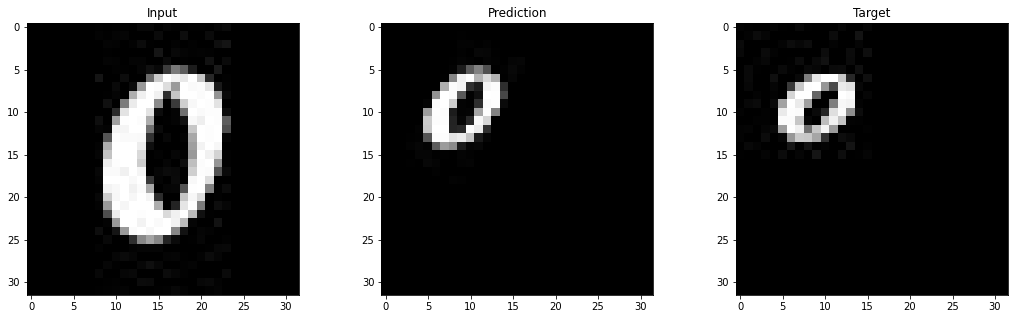

In [70]:
E2E_8b(im_in='img/8bit/zero_centered', im_out='img/8bit/zero_tf', lr=0.0002, n_epochs=800, seed=410, device="cuda", prnt_every=100)

Data preparation
Model training
00:14:51 --- Epoch: 99	Train loss: 0.0843
00:14:53 --- Epoch: 199	Train loss: 0.0622
00:14:55 --- Epoch: 299	Train loss: 0.0311
00:14:56 --- Epoch: 399	Train loss: 0.0298
00:14:58 --- Epoch: 499	Train loss: 0.0298
00:15:00 --- Epoch: 599	Train loss: 0.0298
00:15:01 --- Epoch: 699	Train loss: 0.0298
00:15:03 --- Epoch: 799	Train loss: 0.0298
Model evaluation
Proposed transformation Params:
-Scale: tensor([[1.7715]], device='cuda:0')
-Theta: tensor([[-0.7087]], device='cuda:0')
-Trans_x: tensor([[-0.1779]], device='cuda:0')
-Trans_y: tensor([[0.9381]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


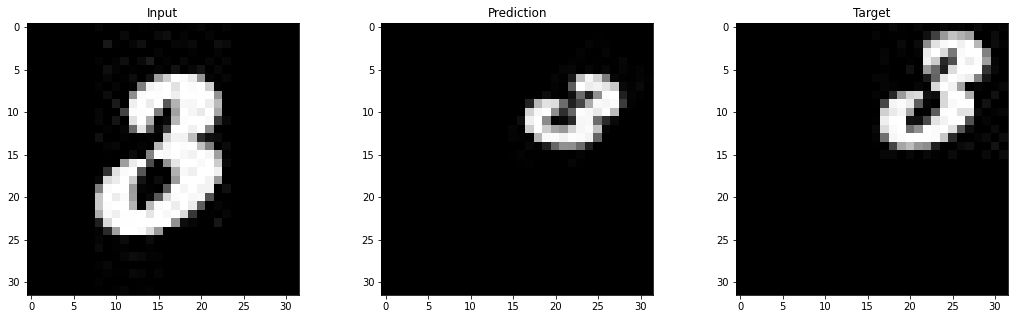

In [78]:
E2E_8b(im_in='img/8bit/three_centered', im_out='img/8bit/three_tf', lr=0.0003, n_epochs=800, seed=415, device="cuda", prnt_every=100)

Data preparation
Model training
00:13:13 --- Epoch: 99	Train loss: 0.0093
Model evaluation
Proposed transformation Params:
-Scale: tensor([[0.7471]], device='cuda:0')
-Theta: tensor([[0.2338]], device='cuda:0')
-Trans_x: tensor([[0.4724]], device='cuda:0')
-Trans_y: tensor([[-0.4736]], device='cuda:0')
Shape of prediction: torch.Size([1, 1, 32, 32])
Images:


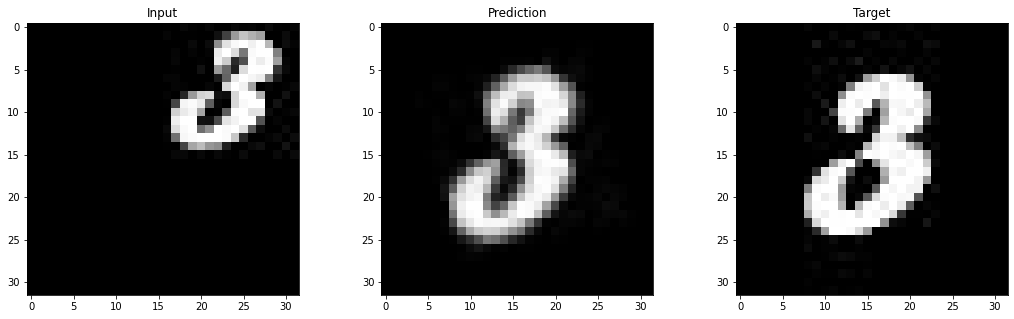

In [72]:
E2E_8b(im_in='img/8bit/three_tf', im_out='img/8bit/three_centered', lr=0.05, n_epochs=150, seed=415, device="cuda", prnt_every=100)

# RGB:

In [83]:
class AttentionTransformationRGB(nn.Module):

    def __init__(self, device, img_size):
        super().__init__()
        
        self.device = device
        self.img_size = img_size
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5,5), stride=(3,3)),
            nn.LeakyReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=(2,2)),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, stride=(2,2)),
            
        )
        
        self.transf_ff = nn.Sequential(
            nn.Linear(in_features=270, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=4)
        )
        
        self.scale_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
        )
        
        self.rot_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1)
        )
        
        self.trans_x_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        ) 
            
        self.trans_y_ff = nn.Sequential(
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh()
        )
        
        # zeroing transformation weights
        with torch.no_grad():
            self.transf_ff[0].weight.data.zero_()
            self.transf_ff[2].weight.data.zero_()            
            self.scale_ff[0].weight.data.zero_()            
            self.rot_ff[0].weight.data.zero_()            
            self.trans_x_ff[0].weight.data.zero_()                       
            self.trans_y_ff[0].weight.data.zero_()


    def forward(self, x_inp, is_evaling=False):
        x = self.feature_extractor(x_inp)
        x = torch.flatten(x, 1)
        trans = self.transf_ff(x)
        
        trans_x = self.trans_x_ff(trans)
        trans_y = self.trans_y_ff(trans)
        scale_factor = torch.exp(self.scale_ff(trans))
        rot_factor = self.rot_ff(trans)
        
        img = transform_img(x=x_inp, theta=rot_factor, scale_factor=scale_factor, device=self.device, trans_x=trans_x, trans_y=trans_y)
        
        if is_evaling:
            print("Params:\n-Scale: " + str(scale_factor)+ "\n-Theta: " + str(rot_factor)+"\n-Trans_x: " + str(trans_x)+"\n-Trans_y: " + str(trans_y))
        
        return img

In [88]:
def evaluate_model_rgb(model, train_loader, device):
  img_inp, img_out = next(iter(train_loader))
  
  print("Proposed transformation", end=" ")
  with torch.no_grad():
    y = model(img_inp.to(device),is_evaling=True)
  
  print(f"Shape of prediction: {y.shape}")
  
  print(f"Images:")
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  ax[0].title.set_text("Input")
  ax[0].imshow(img_inp.detach().cpu().squeeze(0).permute(1,2,0))
  ax[1].title.set_text("Prediction")
  ax[1].imshow(y.detach().cpu().squeeze(0).permute(1,2,0))
  ax[2].title.set_text("Target")
  ax[2].imshow(img_out.detach().cpu().squeeze(0).permute(1,2,0))
  plt.show()
  
def E2E_RGB(im_in, im_out, lr, n_epochs, seed, device, prnt_every=30):
    print("Data preparation")
    img_in, img_out = get_data_rgb(img_in_path=im_in, img_out_path=im_out, img_size=IMG_SIZE_RGB)
    train_loader = DataLoader(dataset=CustomTestDataset(img_in, img_out), batch_size=1, shuffle=False)
    torch.manual_seed(seed)
    
    print("Model training")
    model = AttentionTransformationRGB(device, IMG_SIZE_RGB).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss(reduction="mean")
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, n_epochs, device, print_every=prnt_every)
    
    print("Model evaluation")
    evaluate_model_rgb(model, train_loader, device)

Data preparation
Model training
00:37:50 --- Epoch: 99	Train loss: 0.0201
00:37:52 --- Epoch: 199	Train loss: 0.0201
00:37:55 --- Epoch: 299	Train loss: 0.0201
Model evaluation
Proposed transformation Params:
-Scale: tensor([[0.6603]], device='cuda:0')
-Theta: tensor([[-0.1954]], device='cuda:0')
-Trans_x: tensor([[0.2100]], device='cuda:0')
-Trans_y: tensor([[0.1285]], device='cuda:0')
Shape of prediction: torch.Size([1, 3, 500, 500])
Images:


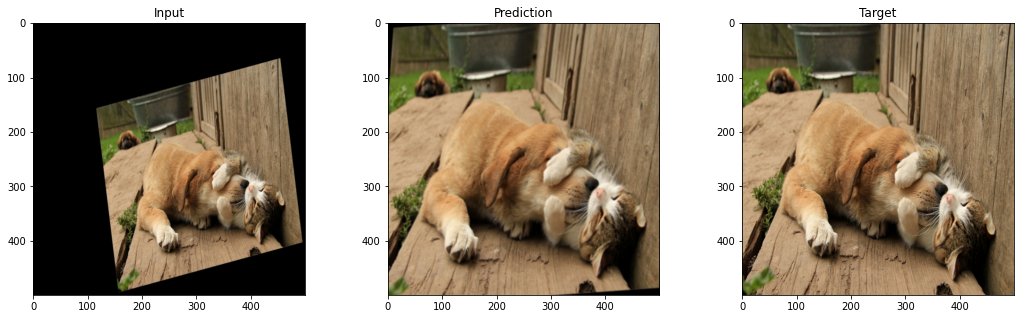

In [93]:
E2E_RGB(im_in='img/rgb/dog_cat_transf', im_out='img/rgb/dog_cat', lr=0.01, n_epochs=300, seed=420, device="cuda", prnt_every=100)

Data preparation
Model training
00:37:28 --- Epoch: 99	Train loss: 0.0426
00:37:30 --- Epoch: 199	Train loss: 0.0342
00:37:33 --- Epoch: 299	Train loss: 0.0347
Model evaluation
Proposed transformation Params:
-Scale: tensor([[0.3286]], device='cuda:0')
-Theta: tensor([[0.5608]], device='cuda:0')
-Trans_x: tensor([[-0.4471]], device='cuda:0')
-Trans_y: tensor([[-0.3715]], device='cuda:0')
Shape of prediction: torch.Size([1, 3, 500, 500])
Images:


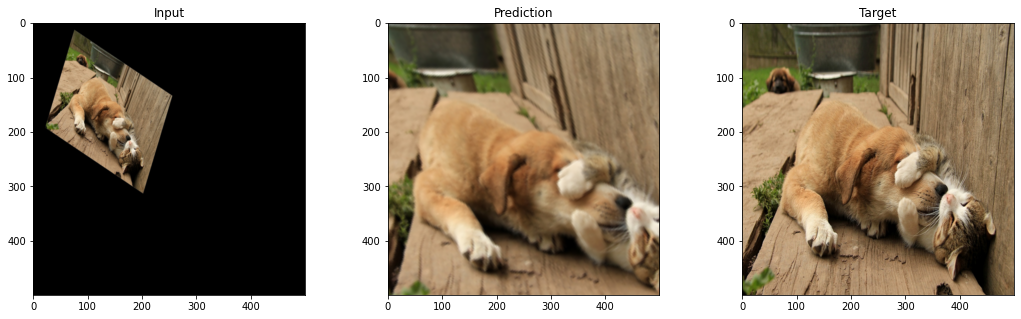

In [92]:
E2E_RGB(im_in='img/rgb/dog_cat_transf2', im_out='img/rgb/dog_cat', lr=0.001, n_epochs=300, seed=420, device="cuda", prnt_every=100)